# PA005: High Value Costumers Identification

## 0.0. Planejamento da Solução (IoT)

### Input - Entrada

1. Problema de Negócio:
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização
    
2. Conjuntos de Dados:
    - Vendas de um e-commerce online, durante um período de um ano.

### Output - Saída

1. A indicação das pessoas que farão parte do programa Insiders:
    - Lista: client_id | is_insider |
             10232     | yes/1
             32412     | yes/1
    
2. Relatório com as respostas das perguntas de negócios:
    - Quem são as pessoas elegíveis para participar do programa de Insiders?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes?
    - Qual a porcentagem de contribuição do faturamento, vindo dos Insiders?
    - Qual a expectativa de faturamento desse grupo para os próximos meses?
    - Quais as condições para uma pessoa ser elegível ao Insiders?
    - Quais as condições para uma pessoa ser removida do Insiders?
    - Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?


### Tasks - Tarefas

1. Quem são as pessoas elegíveis para participar do programa de Insiders?
    - O que é ser elegível ? O que são clientes de maior "valor" ?
    - Faturamento:
        - Alto Ticket médio.
        - Alto LTV.
        - Baixo recência.
        - Alto basket size.
        - Baixa probabilidade de churn.
        - Alta previsão LTV.
        - Alta propensão de compra.
        
    - Custo:
        - Baixa taxa de devolução.
        
    - Experiência de compra:
        - Média alta das avaliações
        
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo Insiders
    
    
3. Quais as principais características desses clientes?
    - Escrever características do cliente: 
        - Idade
        - Localização 
        
    - Escrever características de consumo: 
        - Atributos da clusterização
        
4. Qual a porcentagem de contribuição do faturamento, vindo dos Insiders?
    - Faturamento total da empresa
    - Faturamento do grupo Insiders


5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    - LTV do grupo Insiders
    - Análise de Cohort


6. Quais as condições para uma pessoa ser elegível ao Insiders?
    - Definir a peridiocidade ( 1 mês, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa do grupo


7. Quais as condições para uma pessoa ser removida do Insiders?
    - Definir a peridiocidade ( 1 mês, 3 meses)
    - A pessoa precisa ser desimilar ou parecido com uma pessoa do grupo


8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de Hipóteses.


9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferencia de compra
    - Frete
    - Visita a fabrica

# 0.0 Imports

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import umap.umap_        as umap
import sweetviz          as sv
import re
import inflection
import warnings

from IPython.display     import HTML
from sklearn.manifold    import TSNE
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from matplotlib          import colormaps     as cm
from sklearn             import preprocessing as pp
from sklearn             import cluster       as c
from sklearn             import metrics       as m
from sklearn             import manifold      as mn
from plotly              import express       as px

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    """ Optimize general settings, standardize plot sizes, etc. """
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 12
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
#     pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)
#     pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
#     pd.set_option('display.max_colwidth', -1)
    
jupyter_settings()

warnings.filterwarnings("ignore", category=FutureWarning)

## 0.2. Load Data

In [3]:
# Load Data
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding='ISO-8859-1')

df_raw = df_raw.loc[:,['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate','UnitPrice', 'CustomerID', 'Country']]

# 1.0. DESCRIÇÃO DOS DADOS

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
# Get current columns name
cols_old = df1.columns

# Function to underscore
snakecase = lambda x: inflection.underscore(x)

# New columns name list
cols_new = list( map(snakecase, cols_old) )

# rename columns
df1.columns = cols_new

## 1.2. Data Dimensions

In [6]:
print('Number of rows:', df1.shape[0])
print('Number of columns:', df1.shape[1])

Number of rows: 541909
Number of columns: 8


## 1.3. Data types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [9]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]
df_missing.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,29-Nov-16,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,29-Nov-16,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,29-Nov-16,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,29-Nov-16,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,29-Nov-16,1.66,NaN,United Kingdom


In [10]:
# create reference 
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1 ) 

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left')

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x','customer_id_y'] , axis=1)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [11]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [12]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [13]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [14]:
# invoice_date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format= '%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype('int64') 

In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive Statistics

In [16]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [17]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - desvio padrão, mínimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis() ) ).T

# concatenate
stats = pd.concat( [d2,d3,d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
stats.columns = ['atributes','min','max','range','mean','median','std','skew','kurtosis']
stats

,atributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.7.1.1. Numerical Attributes Investigating

- Quantity Negative ( pode ser devolução )
- Preço unitário igual a zero ( pode ser promoção ? )

### 1.7.2. Categorical Attributes

In [18]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### Invoice No

In [19]:
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool( re.search( '[^0-9]+', x ) ) ), : ]

print('Total number of invoices: {}' .format(len( df_letter_invoices )))
print('Total number of negatives quantity: {}' .format(len( df_letter_invoices.loc[df_letter_invoices['quantity'] < 0] )))

Total number of invoices: 9291
Total number of negatives quantity: 9288


#### Stock Code

In [20]:
# check stock_code only characters
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Ação
## Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [21]:
df1.head()

# Ação: delete description - Aparentemente ela não é significativa

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


#### Country

In [22]:
df1['country'].value_counts(normalize=True)

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
                    ...   
Lithuania         0.000065
Brazil            0.000059
Czech Republic    0.000055
Bahrain           0.000035
Saudi Arabia      0.000018
Name: country, Length: 38, dtype: float64

In [23]:
df1[['customer_id','country']].drop_duplicates().loc[:,['country']].value_counts(normalize=True)

country       
United Kingdom    0.937824
Germany           0.011743
France            0.011125
EIRE              0.005439
Spain             0.003832
                    ...   
RSA               0.000124
Saudi Arabia      0.000124
Singapore         0.000124
Iceland           0.000124
Brazil            0.000124
Length: 38, dtype: float64

# 2.0. Filtragem de Variáveis

In [24]:
df2 = df1.copy()

In [25]:
# === Numerical Attributes ===
df2 = df2.loc[df2['unit_price'] >= 0.04, :] ## Há itens estranhos com preço de 0.00 até 0.03

# === Categorical Attributes ===
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] )]

# description
df2 = df2.drop( columns='description', axis=1 )

# map
df2 = df2[ ~df2['country'].isin(['Unspecified','European Community']) ] 

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns = df2.loc[df2['quantity'] < 0 , :]
df2_purchase = df2.loc[df2['quantity'] >= 0 , :]

# 3.0. Feature Engineering

In [26]:
df3 = df2.copy()

## 3.1. Feature Creation

In [27]:
# data reference
df_ref = df3.loc[:, ['customer_id']].drop_duplicates( ignore_index=True )


# cols_drop = ['invoice_no','stock_code','quantity','invoice_date','unit_price','country']
# df_ref = df3.drop( cols_drop, axis=1).drop_duplicates( ignore_index=True )

### 3.1.1. Gross Revenue

In [28]:
# Gross Revenue (Faturamento) : quantity*price
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

# Monetary 
df_monetary = df2_purchase.loc[:, ['customer_id','gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

C:\Users\leonardo.ribeiro\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Day since last purchase

In [29]:
# Recency - Last day purchase
df_recency = df2_purchase.loc[: , ['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency.loc[:, ['customer_id','recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3. Quantity of purchased

In [30]:
# Numero de produtos
df_freq = ( df2_purchase.loc[:,['customer_id','invoice_no']].drop_duplicates( )
                                                            .groupby('customer_id')
                                                            .count()
                                                            .reset_index()
                                                            .rename(columns={'invoice_no':'qtde_invoices'}) )

df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### 3.1.4. Quantity of items purchased

In [31]:
# Numero de produtos
df_freq = ( df2_purchase.loc[:,['customer_id','quantity']].groupby('customer_id')
                                                          .sum()
                                                          .reset_index()
                                                          .rename(columns={'quantity':'qtde_items'}) )


df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

### 3.1.5. Quantity of products purchased

In [32]:
# Numero de produtos
df_freq = ( df2_purchase.loc[:,['customer_id','stock_code']].groupby('customer_id')
                                                            .count()
                                                            .reset_index()
                                                            .rename(columns={'stock_code':'qtde_product'}) )


df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_product     91
dtype: int64

### 3.1.6. Average Ticket value

In [33]:
# Avg ticket
df_avg_ticket = df2_purchase.loc[:,['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_product     91
avg_ticket       91
dtype: int64

### 3.1.7. Average Recency Days

In [34]:
# Average Recency Days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id','invoice_date'], ascending=[False,False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # desloca a coluna em uma linha
df_aux['previous_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id']==x['next_customer_id'] else np.nan, axis=1 )
# df_aux['avg_recency_days'] = df_aux['avg_recency_days'] * -1

df_aux = df_aux.drop( ['invoice_date','next_customer_id','previous_date'], axis=1 ).dropna()

# average recency
df_avg_recency_days = df_aux.groupby(['customer_id']).mean().reset_index()

# merge 
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_product          91
avg_ticket            91
avg_recency_days    2816
dtype: int64

In [35]:
df_ref

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_product,avg_ticket,avg_recency_days
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,-35.500000
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,-27.250000
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,-23.187500
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,-92.666667
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,-8.600000
...,...,...,...,...,...,...,...,...
5781,22706,5699.00,1.0,1.0,1747.0,634.0,8.988959,NaN
5782,22707,6756.06,0.0,1.0,2010.0,730.0,9.254877,NaN
5783,22708,3217.20,0.0,1.0,654.0,59.0,54.528814,NaN
5784,22709,3950.72,0.0,1.0,731.0,217.0,18.206083,NaN


### 3.1.8. Frequency Purchase

In [36]:
df_aux = ( df2_purchase[['customer_id','invoice_no','invoice_date']].drop_duplicates()
                                                                    .groupby(['customer_id'])
                                                                    .agg( max_ = ('invoice_date', 'max'), 
                                                                          min_ = ('invoice_date','min'),
                                                                          days_ = ('invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                          buy_ = ('invoice_no', 'count') ) ).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_','days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id','frequency']], on='customer_id', how='left')

### 3.1.9. Number of Returns

In [37]:
# Number of Returns
df_returns = df2_returns[['customer_id','quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, on='customer_id', how='left')
df_ref.loc[df_ref['qtde_returns'].isna(),['qtde_returns']] = 0
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_product          91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

In [38]:
df2_returns.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
154,C536383,35004C,-1,2016-11-29,4.65,United Kingdom,15311
235,C536391,22556,-12,2016-11-29,1.65,United Kingdom,17548
236,C536391,21984,-24,2016-11-29,0.29,United Kingdom,17548
237,C536391,21983,-24,2016-11-29,0.29,United Kingdom,17548
238,C536391,21980,-24,2016-11-29,0.29,United Kingdom,17548


### 3.1.10. Basket Size - Quantidade de Itens por cesta (Quantity)

 - Invoice_no = Compra
 - Stock Code = Produto
 - Quantity = Item

In [39]:
df_aux = ( df2_purchase.loc[: , ['customer_id','invoice_no','quantity']].groupby( 'customer_id' )
                                                                        .agg( n_purchase=('invoice_no','nunique'),
                                                                              n_products=('quantity', 'sum') )
                                                                        .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id','avg_basket_size']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_product          91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### 3.1.11. Unique Basket Size - Quantidade de produtos distintos por compra

In [40]:
df_aux = ( df2_purchase.loc[: , ['customer_id','invoice_no','stock_code']].groupby( 'customer_id' )
                                                                          .agg( n_purchase=('invoice_no','nunique'),
                                                                                n_products=('stock_code', 'count') )
                                                                          .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id','avg_unique_basket_size']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_product                91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 4.0. EDA - (Exploratory Data Analysis)

In [41]:
df4 = df_ref.dropna(axis=0)
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_product              0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1. Univariate Analysis

<b> Métricas para olharmos </b>
1. Clusters Coesos - Separados
2. Métricas
- Min, Max, Range
- Média e Mediana
- Desvio Padrão e Variância
- Coeficiente de Variação ( CV )
- Distribuição


In [42]:
# sweet = sv.analyze(df4)
# sweet.show_html()

## 4.1.1 Gross Revenue

## 4.1.2 Quantidade Items

In [43]:
df4[df4['customer_id'] == 14646]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_product,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,-7.844444,0.20339,288.0,2733.944444,28.611111


## 4.1.3 Avg Tickets

In [44]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_product,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


## 4.1.4 Frequency

In [45]:
df4[df4['frequency'] == 17]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_product,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,-35.5,17.0,40.0,50.970588,8.735294


## 4.1.5 Avg Basket Size

In [46]:
df4[df4['avg_basket_size'] == 40498.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_product,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


## 4.2. Bivariate Analysis

In [47]:
cols = ['customer_id']
df42 = df4.drop(columns=cols, axis=1)

In [48]:
# plt.figure( figsize=(25,12) );
# sns.pairplot( df42 );

**Notes**
1. Frequency has low variance
1. Avg ticket has low variance

## 4.3. Estudo do Espaço

In [49]:
df43 = df4.drop(columns=['customer_id'], axis=1 ).copy()

In [50]:
mm = pp.MinMaxScaler()

In [51]:
df43['gross_revenue']          = mm.fit_transform( df43[['gross_revenue']]  ) 
df43['recency_days']           = mm.fit_transform( df43[['recency_days']]  ) 
df43['qtde_invoices']          = mm.fit_transform( df43[['qtde_invoices']]  ) 
df43['qtde_items']             = mm.fit_transform( df43[['qtde_items']] )
df43['qtde_product']           = mm.fit_transform( df43[['qtde_product']]  ) 
df43['avg_ticket']             = mm.fit_transform( df43[['avg_ticket']]  ) 
df43['avg_recency_days']       = mm.fit_transform( df43[['avg_recency_days']]  ) 
df43['frequency']              = mm.fit_transform( df43[['frequency']] )
df43['qtde_returns']           = mm.fit_transform( df43[['qtde_returns']]  ) 
df43['avg_basket_size']        = mm.fit_transform( df43[['avg_basket_size']]  ) 
df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']] )

In [52]:
X = df43.copy()

In [53]:
from sklearn import decomposition as dd

### 4.3.1. PCA

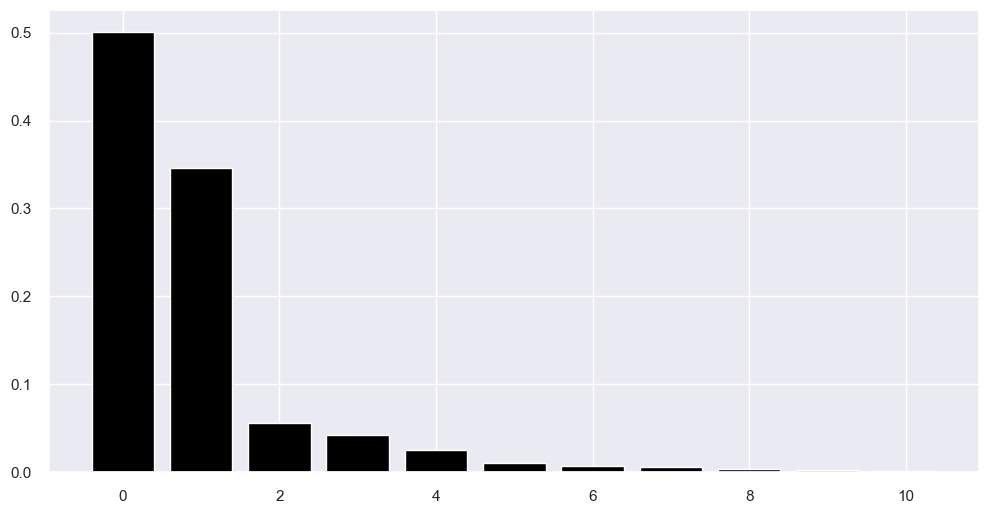

In [54]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variables
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black')

# pca components
df_pca = pd.DataFrame( principal_components )

In [55]:
df_pca

,0,1,2,3,4,5,6,7,8,9,10
0,0.856032,-0.018876,0.044031,0.107428,-0.133946,0.051340,-0.186188,0.945727,0.038060,-0.014428,-0.004511
1,-0.009760,-0.112148,-0.014825,0.001486,-0.014610,0.003567,0.001839,-0.005976,0.000141,-0.002466,0.001499
2,-0.153584,-0.143638,-0.006937,0.037475,-0.005276,-0.001678,-0.014919,-0.002702,-0.007655,-0.008061,-0.002635
3,0.075959,0.079473,-0.053215,0.022346,-0.009995,-0.000006,0.000125,-0.006656,0.000919,-0.000395,0.000129
4,0.736567,-0.075356,-0.039723,0.035937,-0.010376,0.019349,0.008958,-0.030703,0.046670,-0.009117,-0.008029
...,...,...,...,...,...,...,...,...,...,...,...
2963,-0.118562,-0.186099,0.005967,-0.042931,0.041500,-0.004411,-0.006367,0.053657,-0.003279,0.006710,0.001217
2964,-0.126459,-0.190222,-0.073268,-0.000329,0.025570,0.000326,-0.002641,0.039502,0.004216,0.012004,-0.000227
2965,-0.162769,-0.187525,0.312880,-0.248573,-0.037789,0.017242,0.061526,0.019916,0.031945,-0.032562,-0.014027
2966,-0.124212,-0.196356,-0.010857,-0.050901,-0.006158,0.003923,-0.000003,0.113306,0.013662,0.008014,-0.004049


<Axes: xlabel='0', ylabel='1'>

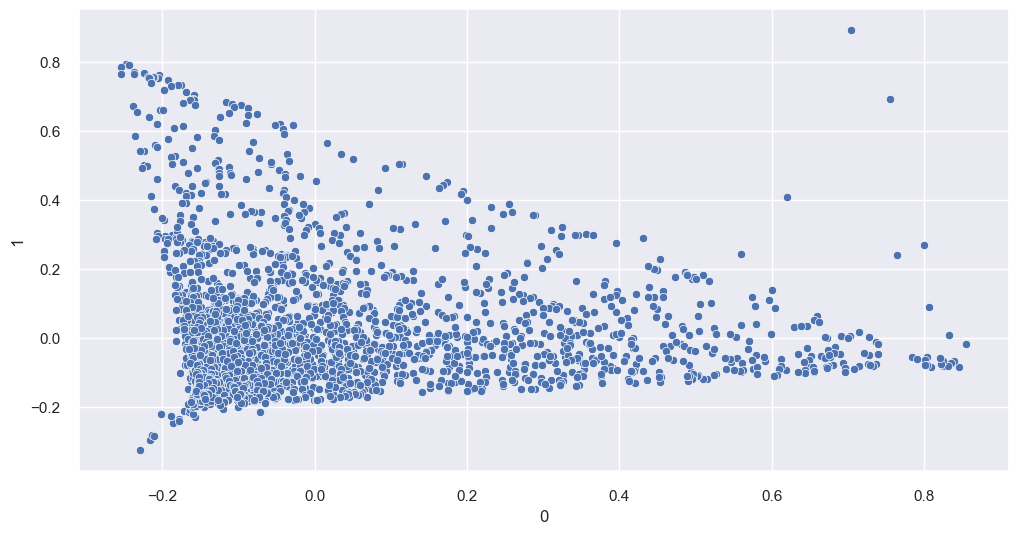

In [56]:
sns.scatterplot( x=0, y=1, data=df_pca )

### 4.3.2. UMAP

C:\Users\leonardo.ribeiro\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

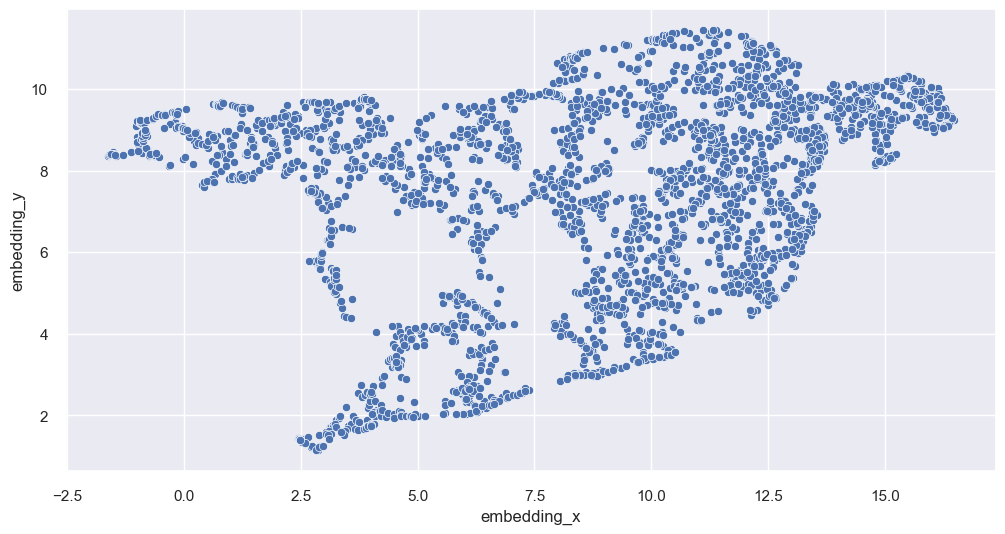

In [57]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_pca ) 

### 4.3.3. t-SNE

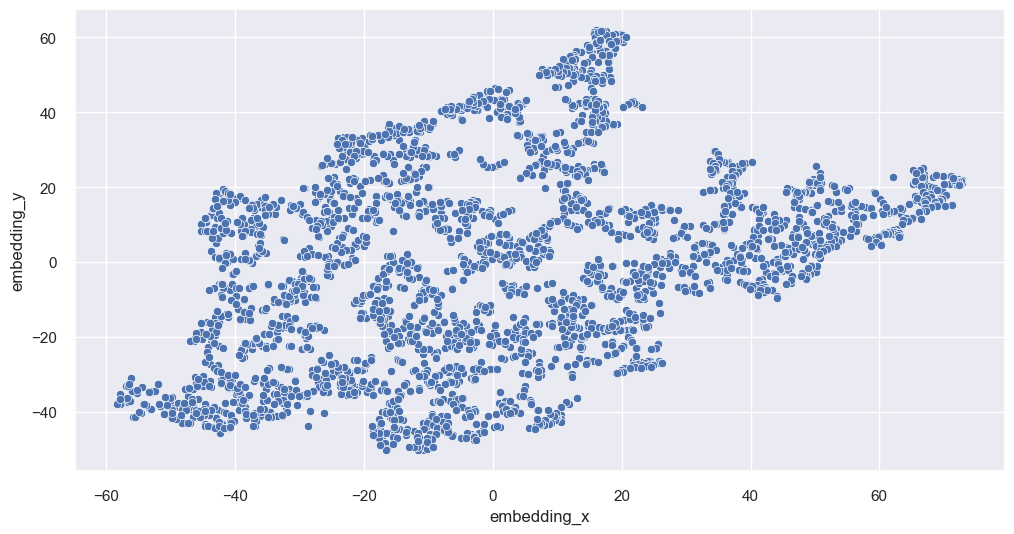

In [58]:
reducer = mn.TSNE( n_components=2, random_state=42, n_jobs=-1 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y', 
                data=df_pca );

### 4.3.4. Tree-Based Embedding

In [59]:
from sklearn import ensemble as en

In [60]:
# training dataset
X = df4.drop(columns=['customer_id','gross_revenue'], axis=1)
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit( X, y )

# Leaf

# dataframe leaf
df_leaf = pd.DataFrame( rf_model.apply( X ) )

In [61]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2991,2716,3323,3340,2764,3147,3227,3129,3174,3364,3154,3293,3079,3188,2780,3205,3016,3174,3102,3268,3065,3081,2905,3297,3358,3323,3270,3015,3090,3041,3308,3383,3354,3339,2952,3243,3410,3146,2944,3029,3278,3202,3221,3134,3177,3142,3284,3334,3343,3140,3195,2920,3139,3389,3377,3204,3169,3367,3220,2977,3421,2884,3335,3254,3019,3043,3301,3326,3084,3304,3343,2990,2702,3261,3116,3160,3304,3105,3217,3048,3250,3238,3050,3079,3285,3153,3288,3196,3133,3271,3184,3178,3175,3059,3042,3127,3186,2831,3356,3319
1,2961,2928,3042,2972,2751,3131,2925,2830,3120,2905,3109,2564,2550,3112,2749,3124,2975,3049,3067,2833,2954,3024,2734,2847,3019,2918,2840,2781,3079,3031,2869,3017,2968,2753,2920,2970,2965,2809,3051,3018,2972,2778,3195,3110,3117,2765,2912,2874,2978,3105,3167,3051,3073,2960,2991,2957,3127,3017,2892,2960,2993,2844,2900,2875,3000,3029,3000,2901,3057,2916,2958,2973,3143,2929,3042,2786,2901,3070,3168,3024,2923,2896,2982,2577,2906,3087,2951,3151,3092,2853,2546,2887,2881,3019,3146,3014,2916,2799,2973,2826
2,3630,3606,3586,3411,3570,3658,3629,3549,3680,3615,3635,3577,3529,3651,3561,3566,3581,3643,3551,3469,3522,3638,3605,3522,3562,3676,3574,3598,3588,3702,3431,3671,3612,3645,3574,3614,3546,3520,3597,3491,3657,3403,3615,3500,3521,3603,3425,3649,3628,3547,3627,3503,3570,3606,3666,3629,3610,3660,3570,3594,3613,3583,3573,3689,3456,3631,3661,3493,3554,3632,3589,3427,3575,3612,3549,3548,3599,3563,3540,3497,3427,3457,3567,3428,3514,3598,3584,3699,3592,3557,3592,3442,3560,3483,3604,3455,3524,3621,3565,3647
3,1275,1412,1758,1489,2018,1453,2109,1443,1665,1718,2034,2297,1343,1604,1522,1986,1884,1597,1924,1412,1830,1429,1464,1495,1145,1477,1509,1527,1990,1307,1944,1515,1506,1450,1540,1556,2162,2204,1660,1480,1496,1470,1461,1765,1527,1496,1441,1396,1356,1665,1812,1497,1350,2216,2092,1493,1556,1737,1298,2125,1478,1904,1887,1780,1479,1489,1375,1762,1035,1359,2303,1583,2179,2173,1273,2044,2031,1495,1914,1467,1918,1405,1495,1651,1482,1488,2050,1341,1659,1543,1871,1747,2026,1881,1921,2241,1453,1195,1982,2105
4,354,719,566,707,137,706,734,687,191,197,578,723,663,194,569,615,575,418,558,413,577,713,416,200,632,211,438,205,147,728,703,201,211,203,232,720,595,203,706,973,516,872,217,593,894,676,286,602,689,606,592,185,749,415,209,549,700,668,720,604,231,743,189,206,671,456,474,561,459,203,711,230,551,621,713,199,721,181,111,226,213,696,757,217,681,162,305,725,689,806,331,192,580,544,196,156,189,704,707,175


C:\Users\leonardo.ribeiro\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

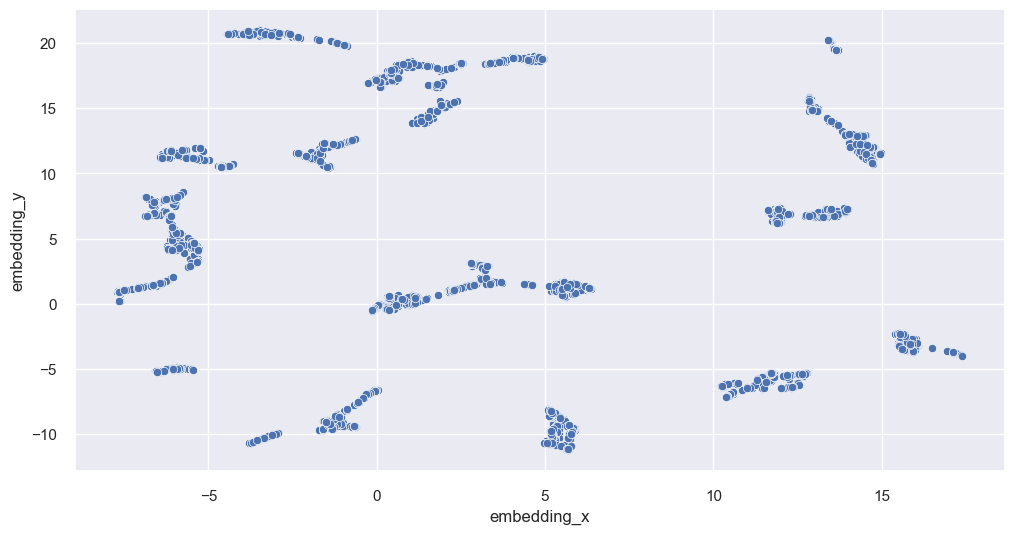

In [62]:
df_embedding = pd.DataFrame()

reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_embedding['embedding_x'] = embedding[:,0]
df_embedding['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x="embedding_x", 
                y="embedding_y", 
                data=df_embedding ) 

# 5.0. DATA PREPARATION

- Padronização (Standardization) -> Premissa que os dados vieram de uma distribuição normal (ou quase normal, com skew)
- Rescala      (Rescale)         -> Não tem a premissa que os dados vieram de uma distribuição normal

**Dica**

1. Distribuição Normal e não possui outlier -> Standard Scaler - média e desvio padrão]
2. Distribuição Normal e possui outlier -> Robust Scaler - Quartis
3. Não distribuição normal -> Min Max Scaler

**Testes de normalidade**
- QQ Plot  - Quantile Quantile Plot ( Quantile Teórica x Quantile Real )
- KS Teste - Kolgomorov Smirnoff ( Teste de Hipótese ) Se p-value >= 0.05 -> Distribuição Normal // p-value < 0.05 -> Não Distribuição Normal

**Detecção de Outlier**
- Box Plot -> Pontos são identificados como Outlier
- IIQ * 2.5 -> acima desse valor ( Outlier )

- Z-Score > 3  -> Outlier
- Z-Score < -3 -> Outlier

In [63]:
# df5 = df4.copy()
# df5_aux = df4.copy()

df5 = df_embedding.copy()

In [64]:
df5.columns

Index(['embedding_x', 'embedding_y'], dtype='object')

In [65]:
# ## Standard Scaler

# mm = pp.MinMaxScaler()
# ss = pp.StandardScaler()
# rs = pp.RobustScaler()

# df5['gross_revenue']          = mm.fit_transform( df5[['gross_revenue']] )
# df5['recency_days']           = mm.fit_transform( df5[['recency_days']] )
# # df5['qtde_invoices']          = mm.fit_transform( df5[['qtde_invoices']] )
# # df5['qtde_items']             = mm.fit_transform( df5[['qtde_items']] )
# df5['qtde_product']           = mm.fit_transform( df5[['qtde_product']] )
# # df5['avg_ticket']             = mm.fit_transform( df5[['avg_ticket']] )
# # df5['avg_recency_days']       = mm.fit_transform( df5[['avg_recency_days']] )
# df5['frequency']              = mm.fit_transform( df5[['frequency']] )
# df5['qtde_returns']           = mm.fit_transform( df5[['qtde_returns']] )
# # df5['avg_basket_size']        = mm.fit_transform( df5[['avg_basket_size']] )
# # df5['avg_unique_basket_size'] = mm.fit_transform( df5[['avg_unique_basket_size']] )

# 6.0. FEATURE SELECTION

In [66]:
# cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_product', 'frequency', 'qtde_returns']

In [67]:
# df6 = df5[ cols_selected ].copy()
df6 = df_embedding.copy()

# 7.0. HYPERPARAMETER FINE-TUNNING

In [68]:
# X = df6.drop(columns=['customer_id'])
X = df_embedding.copy()

In [69]:
X.head()

,embedding_x,embedding_y
0,17.372608,-3.964289
1,12.557136,-6.194443
2,13.639613,13.760060
3,-7.713752,0.881671
4,-0.932450,19.811493


In [70]:
# clusters = [2,3,4,5,6,7]
clusters = np.arange(2,26,1)

## 7.1. K-Means

In [71]:
kmeans_list = []

for k in clusters: 
    # model definition
    kmeans_model = c.KMeans( n_clusters = k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

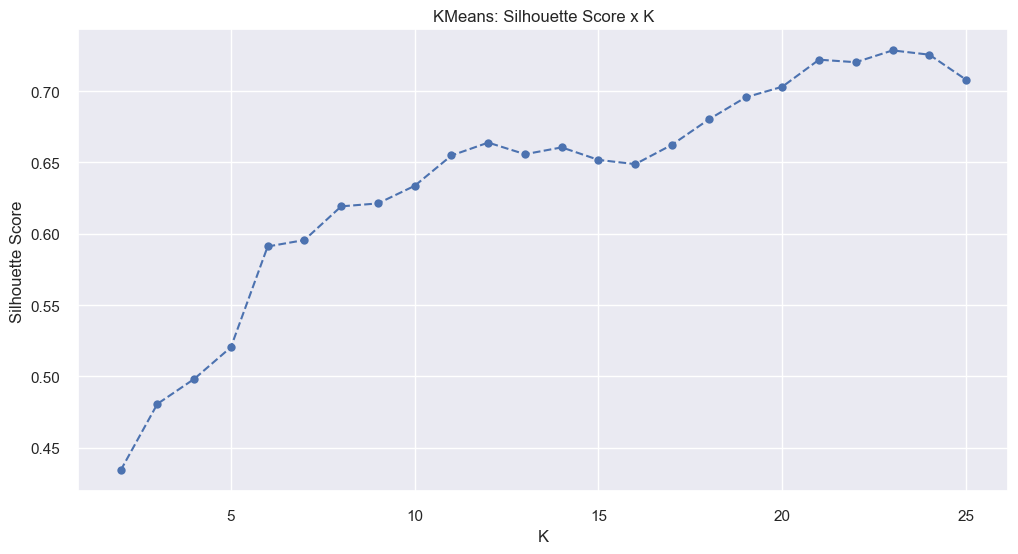

In [72]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )

plt.title( 'KMeans: Silhouette Score x K' )
plt.ylabel('Silhouette Score')
plt.xlabel('K');

## 7.2. GMM

In [73]:
from sklearn import mixture as mx

In [74]:
gmm_list = []

for k in clusters: 
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

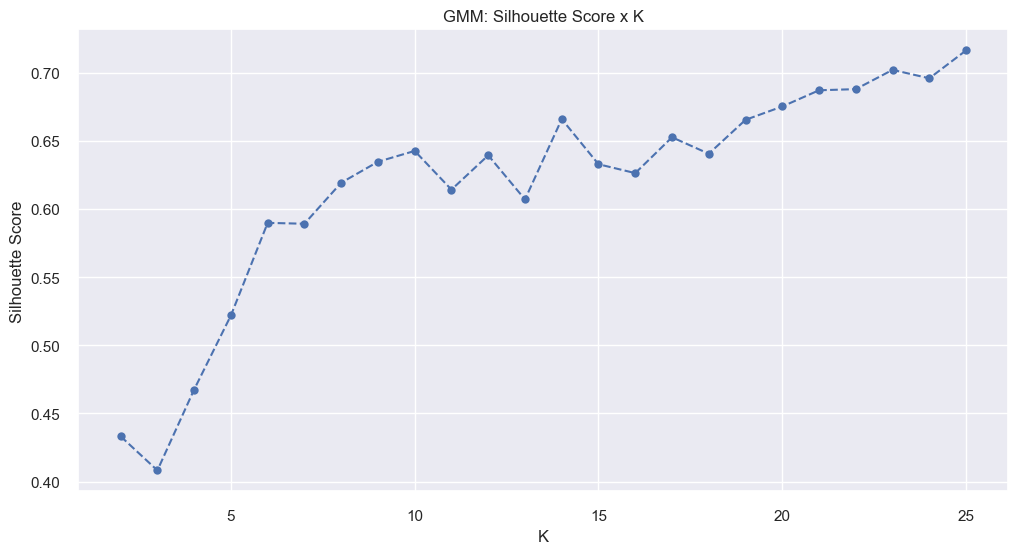

In [75]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )

plt.title( 'GMM: Silhouette Score x K' )
plt.ylabel('Silhouette Score')
plt.xlabel('K');

## 7.3. Hierarchical Clustering

In [76]:
from scipy.cluster import hierarchy as hc

In [77]:
# model definition and training
hc_model = hc.linkage( X, 'ward' )

In [78]:
# hc.dendrogram(hc_model, 
#               leaf_rotation=90, 
#               leaf_font_size=8 
#              )

# plt.plot()

In [79]:
# hc.dendrogram(hc_model, 
#               truncate_mode='lastp',
#               p=12,
#               leaf_rotation=90, 
#               leaf_font_size=8,
#               show_contracted=True
#              )

# plt.plot()

### 7.3.1. HClustering Silhouette Score

In [80]:
hc_list = []

for k in clusters:
    # model definition & training 
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics 
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

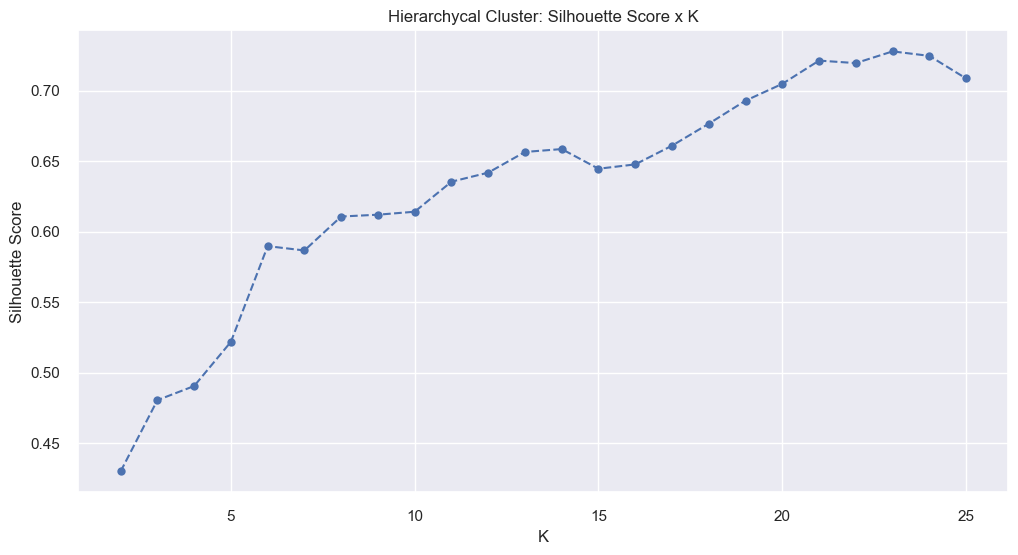

In [81]:
plt.plot( clusters, hc_list, linestyle='--', marker='o', color='b' )

plt.title( 'Hierarchycal Cluster: Silhouette Score x K' )
plt.ylabel('Silhouette Score')
plt.xlabel('K');

## 7.4. DBSCAN

In [82]:
# dbscan_list = []

# for min_samples in range(2,8):
#     eps=0.1
#     # model definition
#     dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

#     # model training & predict
#     labels = dbscan_model.fit_predict( X )
#     sil = m.silhouette_score( X, labels, metric='euclidean' )

#     dbscan_list.append( sil )

## 7.5. Results

In [83]:
# df_results = pd.DataFrame(
#                 {'KMeans': kmeans_list,
#                 'GMM': gmm_list,
#                 'HC': hc_list,
#                 'DBSCAN':dbscan_list}
#                          ).T

df_results = pd.DataFrame(
                {'KMeans': kmeans_list,
                'GMM': gmm_list,
                'HC': hc_list}
                         ).T

df_results.columns = clusters

df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
KMeans,0.434053,0.480692,0.498164,0.520438,0.591090,0.595612,0.619236,0.621299,0.633641,0.654907,0.663966,0.655809,0.660599,0.651832,0.648851,0.662446,0.680194,0.695651,0.703136,0.722108,0.720327,0.728628,0.725615,0.708055
GMM,0.433250,0.408269,0.467580,0.521901,0.589800,0.589152,0.619223,0.634621,0.642559,0.614168,0.639334,0.606997,0.665869,0.632802,0.626279,0.652563,0.640496,0.665360,0.675156,0.687041,0.687872,0.702005,0.695825,0.716292
HC,0.430213,0.480692,0.490688,0.522002,0.589800,0.586724,0.610775,0.612063,0.614175,0.635441,0.641858,0.656519,0.658557,0.644623,0.647703,0.660962,0.676522,0.692857,0.704746,0.721240,0.719459,0.727760,0.724591,0.708585


## 7.6. Silhouette Analysis

 For K = 2. Silhouette Score = 0.4302130341529846
 For K = 3. Silhouette Score = 0.4806917905807495
 For K = 4. Silhouette Score = 0.49068790674209595
 For K = 5. Silhouette Score = 0.522002100944519
 For K = 6. Silhouette Score = 0.5897995233535767
 For K = 7. Silhouette Score = 0.5867235660552979
 For K = 8. Silhouette Score = 0.6107746362686157
 For K = 9. Silhouette Score = 0.6120631098747253
 For K = 10. Silhouette Score = 0.6141751408576965
 For K = 11. Silhouette Score = 0.6354405283927917
 For K = 12. Silhouette Score = 0.6418576836585999
 For K = 13. Silhouette Score = 0.6565185785293579
 For K = 14. Silhouette Score = 0.6585570573806763
 For K = 15. Silhouette Score = 0.6446226239204407
 For K = 16. Silhouette Score = 0.647703230381012
 For K = 17. Silhouette Score = 0.6609618663787842
 For K = 18. Silhouette Score = 0.6765220761299133
 For K = 19. Silhouette Score = 0.6928572654724121
 For K = 20. Silhouette Score = 0.7047458291053772
 For K = 21. Silhouette Score = 0.721240

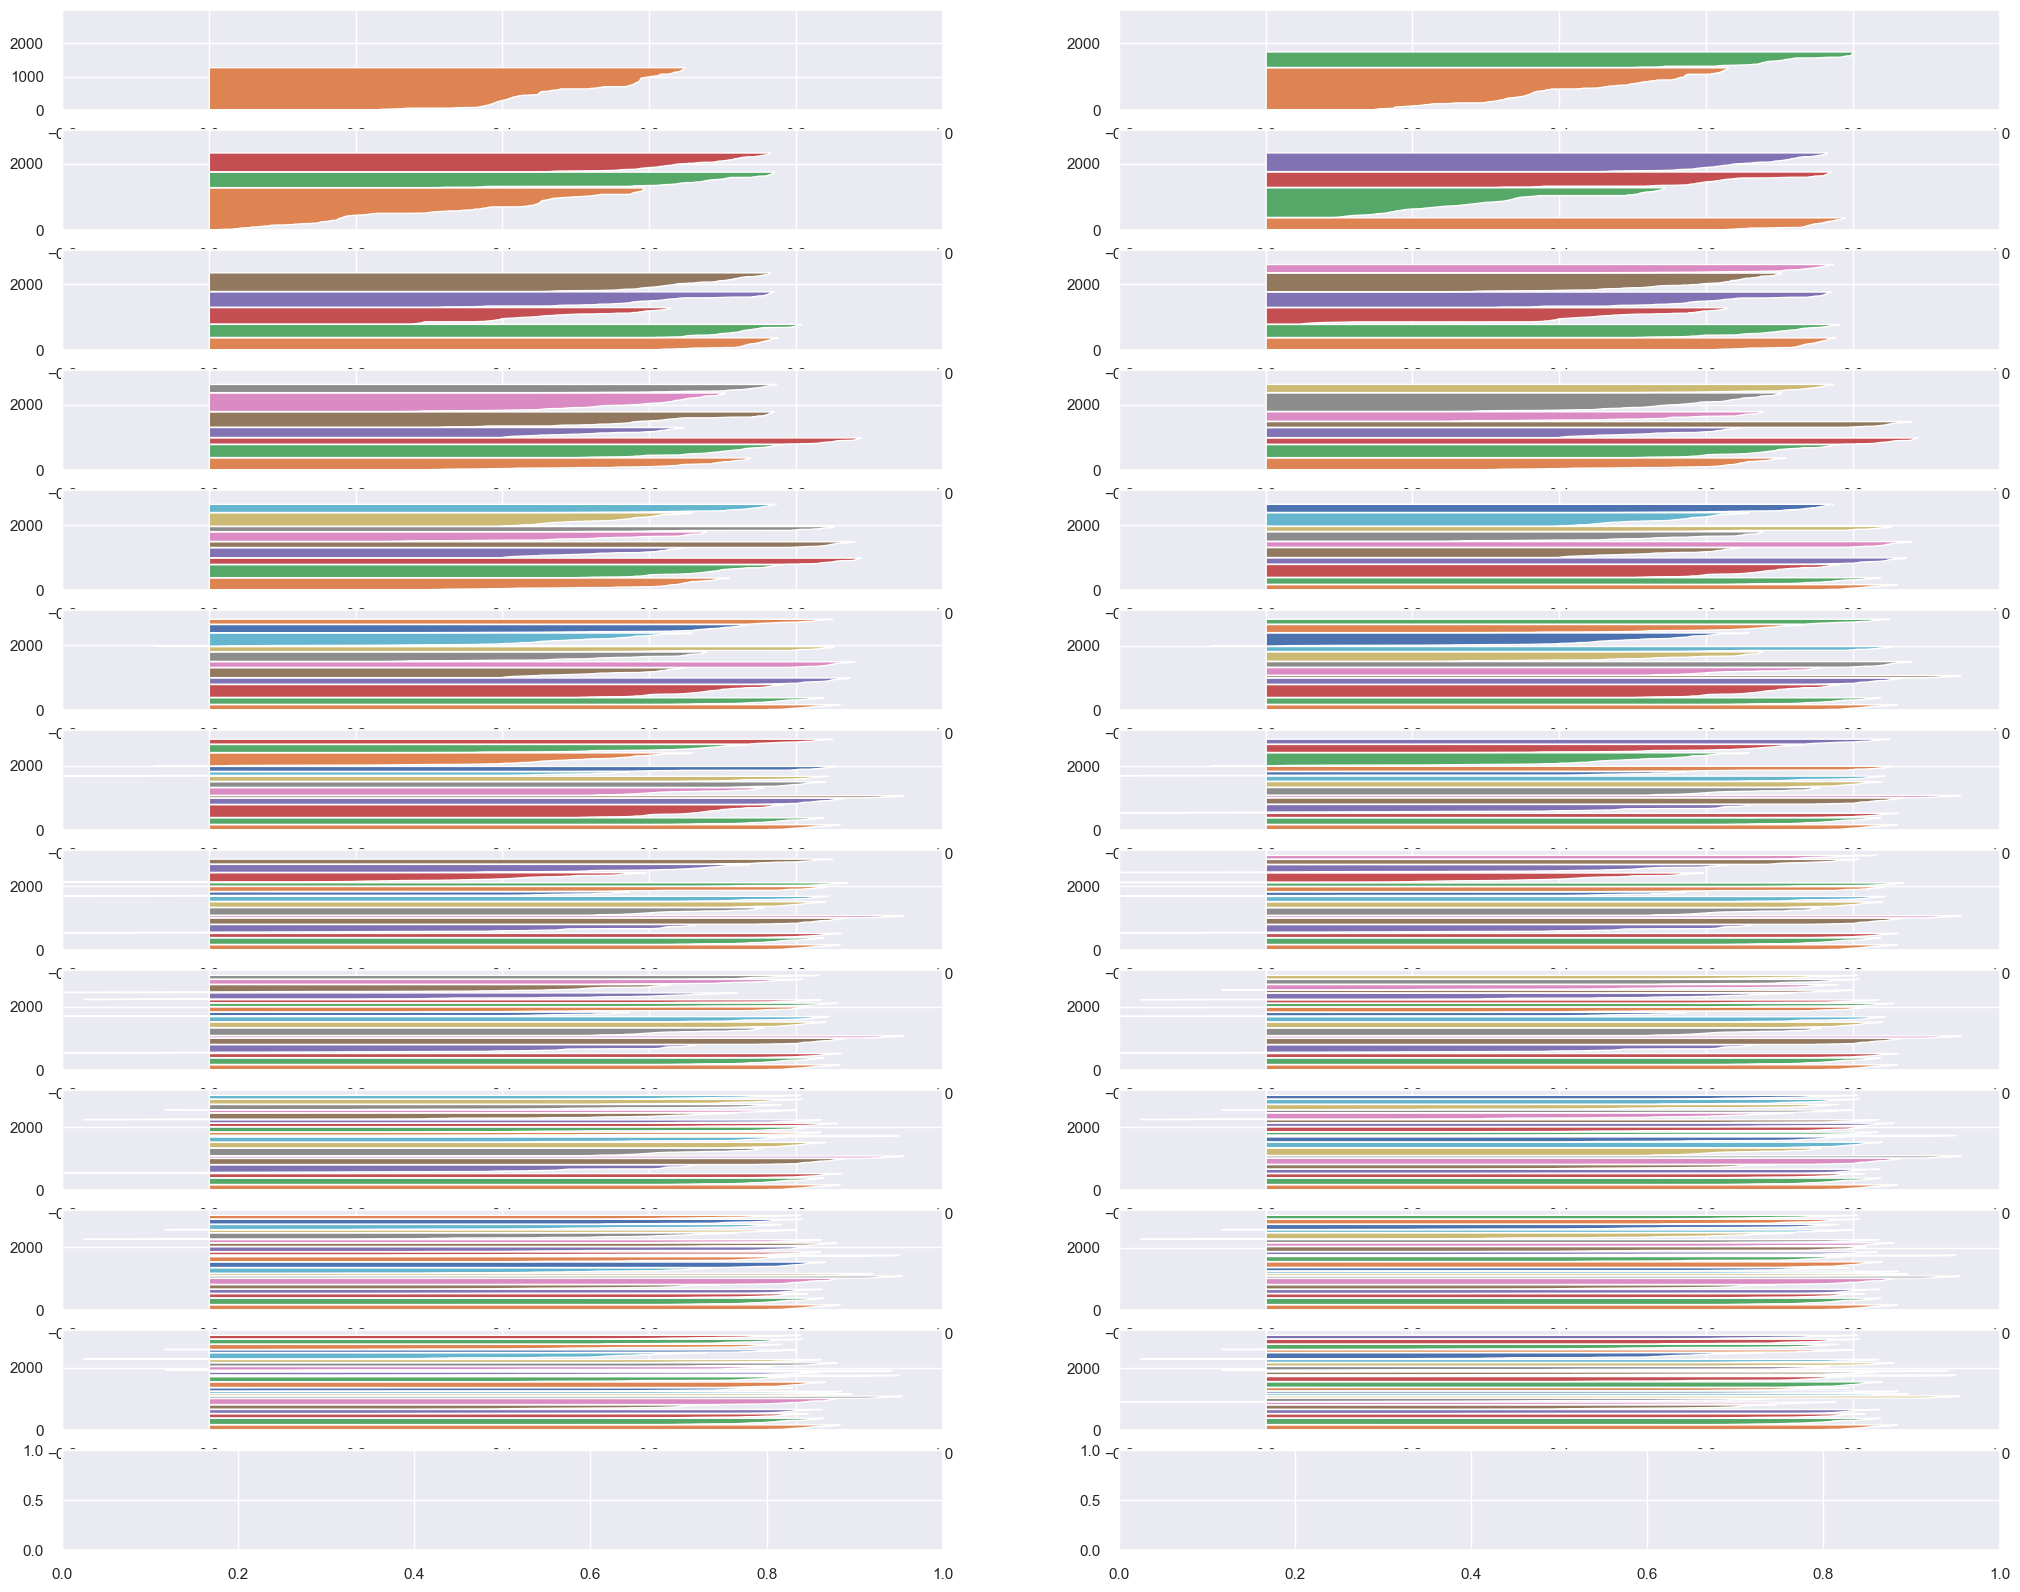

In [84]:
fig, ax = plt.subplots( 13, 2 )
fig.set_size_inches( 25,20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [-0.2, 1] )
    ax[q-1, mod].set_ylim( [0, len( X ) + ( k+1 )*10] )
    
    # model definition & training 
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance 
    ss = m.silhouette_score( X, labels, metric='euclidean' )
    print(' For K = {}. Silhouette Score = {}' .format( k, ss ))
    
    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
        
    for i in range( k ):

        
        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i ]
        
        # size clusters 
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        
        # sort values
        ith_samples_silhouette_values.sort()
        
        # limits
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )
        
        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper), 0, ith_samples_silhouette_values)
        
        y_lower = y_upper + 10

# 8.0. MODEL TRAINING

## 8.1. K-Means

In [85]:
# model definition
k = 10

# kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )
kmeans = c.KMeans( n_clusters = k )
# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

In [86]:
#### TESTE ####
k = 13

# model definition
kmeans = mx.GaussianMixture( n_components=k )

# model training
kmeans.fit( X )

# model predict
labels = kmeans.predict( X )

## 8.2. Cluster Validation

In [87]:
## WSS ( Within-cluster sum of square )
print('WSS value: {}' .format(kmeans.inertia_) )

## SS ( Silhouette Score )
print('SS value: {:.4f}' .format( m.silhouette_score( X, labels, metric='euclidean') ) )

AttributeError: 'GaussianMixture' object has no attribute 'inertia_'

# 9.0. CLUSTER ANALYSIS

In [88]:
# df9 = df4.copy()
# df9['cluster'] = labels

df9 = X.copy()
df9['cluster'] = labels

df9.head()

,embedding_x,embedding_y,cluster
0,17.372608,-3.964289,10
1,12.557136,-6.194443,6
2,13.639613,13.760060,7
3,-7.713752,0.881671,5
4,-0.932450,19.811493,9


## 9.1. Visualization Inspection

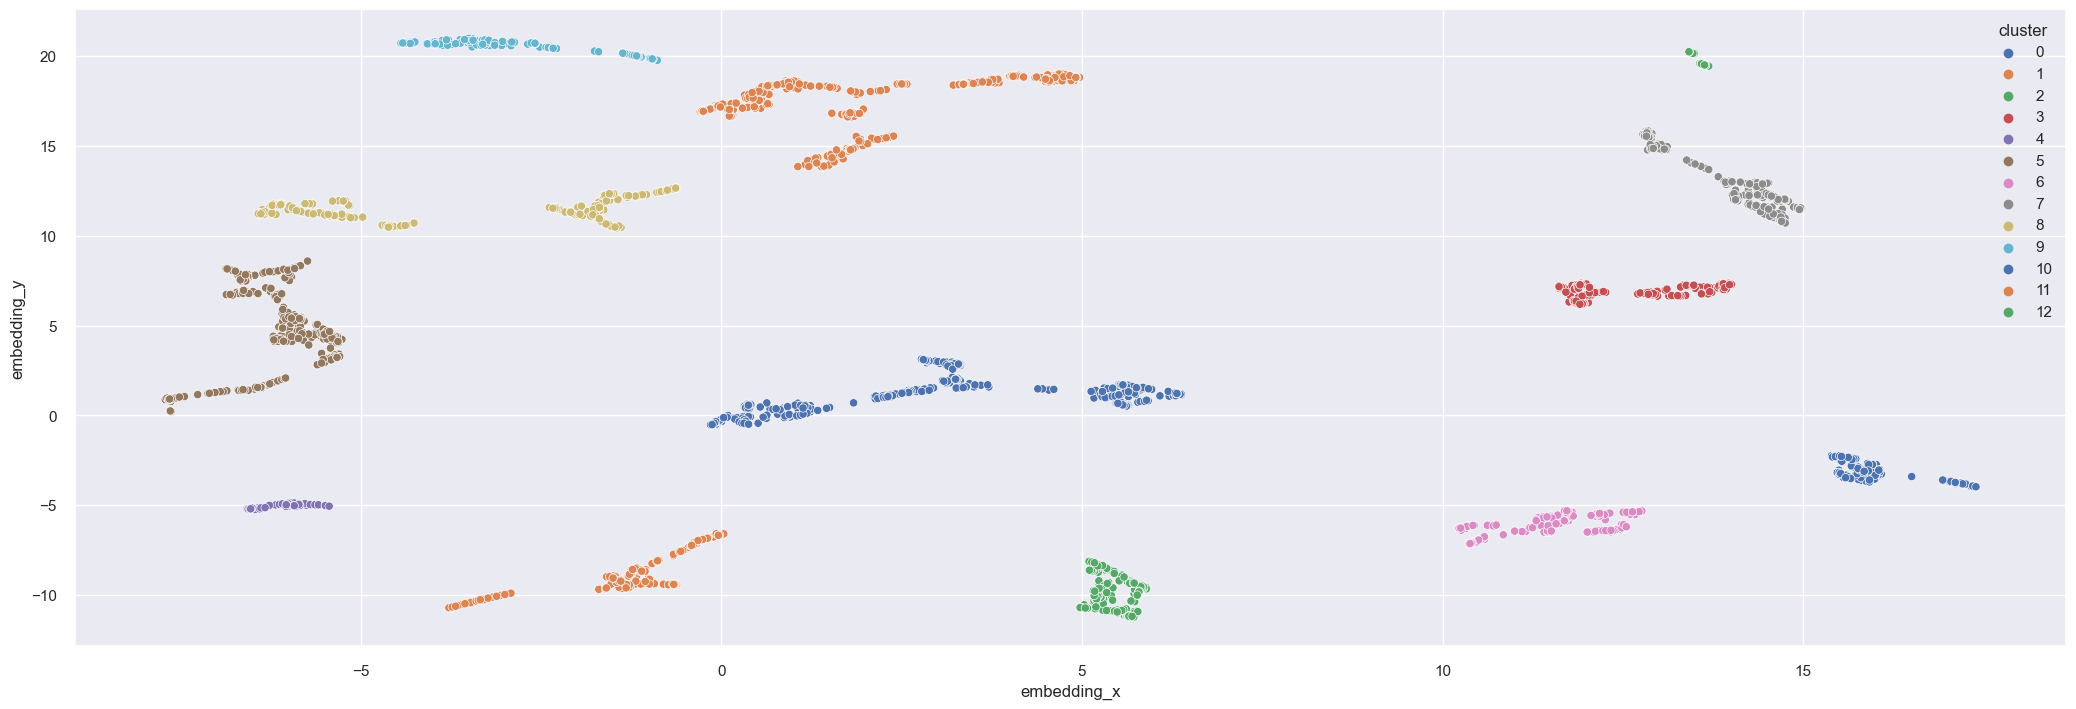

In [89]:
# GMM

sns.set(rc={'figure.figsize':(25.7,8.27)})

sns.scatterplot(x='embedding_x', y='embedding_y', 
                hue='cluster', 
#                 palette=sns.color_palette('hls', n_colors=len( df9['cluster'].unique() ) ),
                palette='deep', 
                data=df9 );

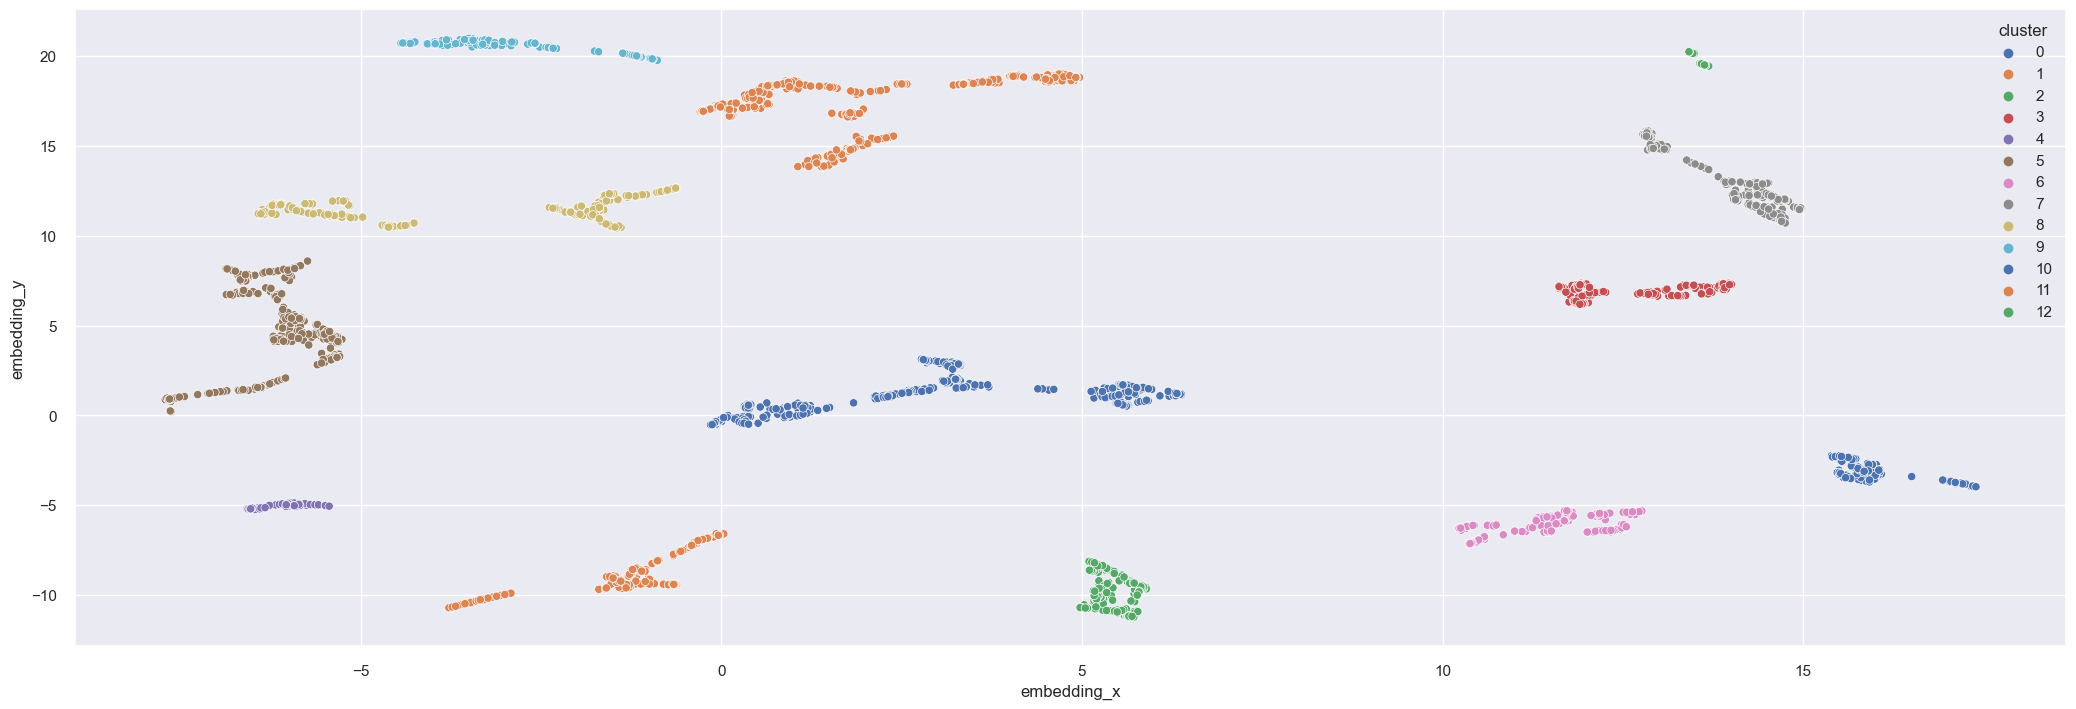

In [90]:
sns.set(rc={'figure.figsize':(25.7,8.27)})

sns.scatterplot(x='embedding_x', y='embedding_y', 
                hue='cluster', 
#                 palette=sns.color_palette('hls', n_colors=len( df9['cluster'].unique() ) ),
                palette='deep', 
                data=df9 );

In [91]:
# visualizer = SilhouetteVisualizer( kmeans, color='yellowbrick')
# visualizer.fit( X )
# visualizer.finalize()

## 9.2. 2d plot

- Ao plotar as features em pares, conseguimos ver se os dados estão bagunçados ou não, ou seja, se os clusteres estão bem divididos ou não. 
- A desvantagem é que ao plotar em 2D pode ser que alguma informação seja perdida, por exemplo, pode ser que na alta dimensionalidade (3 features ou +) , os clusteres ficariam bem divididos

In [93]:
df9.head()

,embedding_x,embedding_y,cluster
0,17.372608,-3.964289,10
1,12.557136,-6.194443,6
2,13.639613,13.760060,7
3,-7.713752,0.881671,5
4,-0.932450,19.811493,9


In [94]:
# df_viz = df9.drop(columns=['customer_id'], axis=1 )

# df_viz['cluster'] = df_viz['cluster'].astype('int64')

In [ ]:
# sns.pairplot( df_viz ) #, hue='cluster' );

## 9.3. UMAP

- Pontos da mesma cor próximos um dos outros, significa que na alta dimensionalidade há uma alta probabilidade de também estarém próximos

In [97]:
df_viz = df9.copy()

C:\Users\leonardo.ribeiro\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

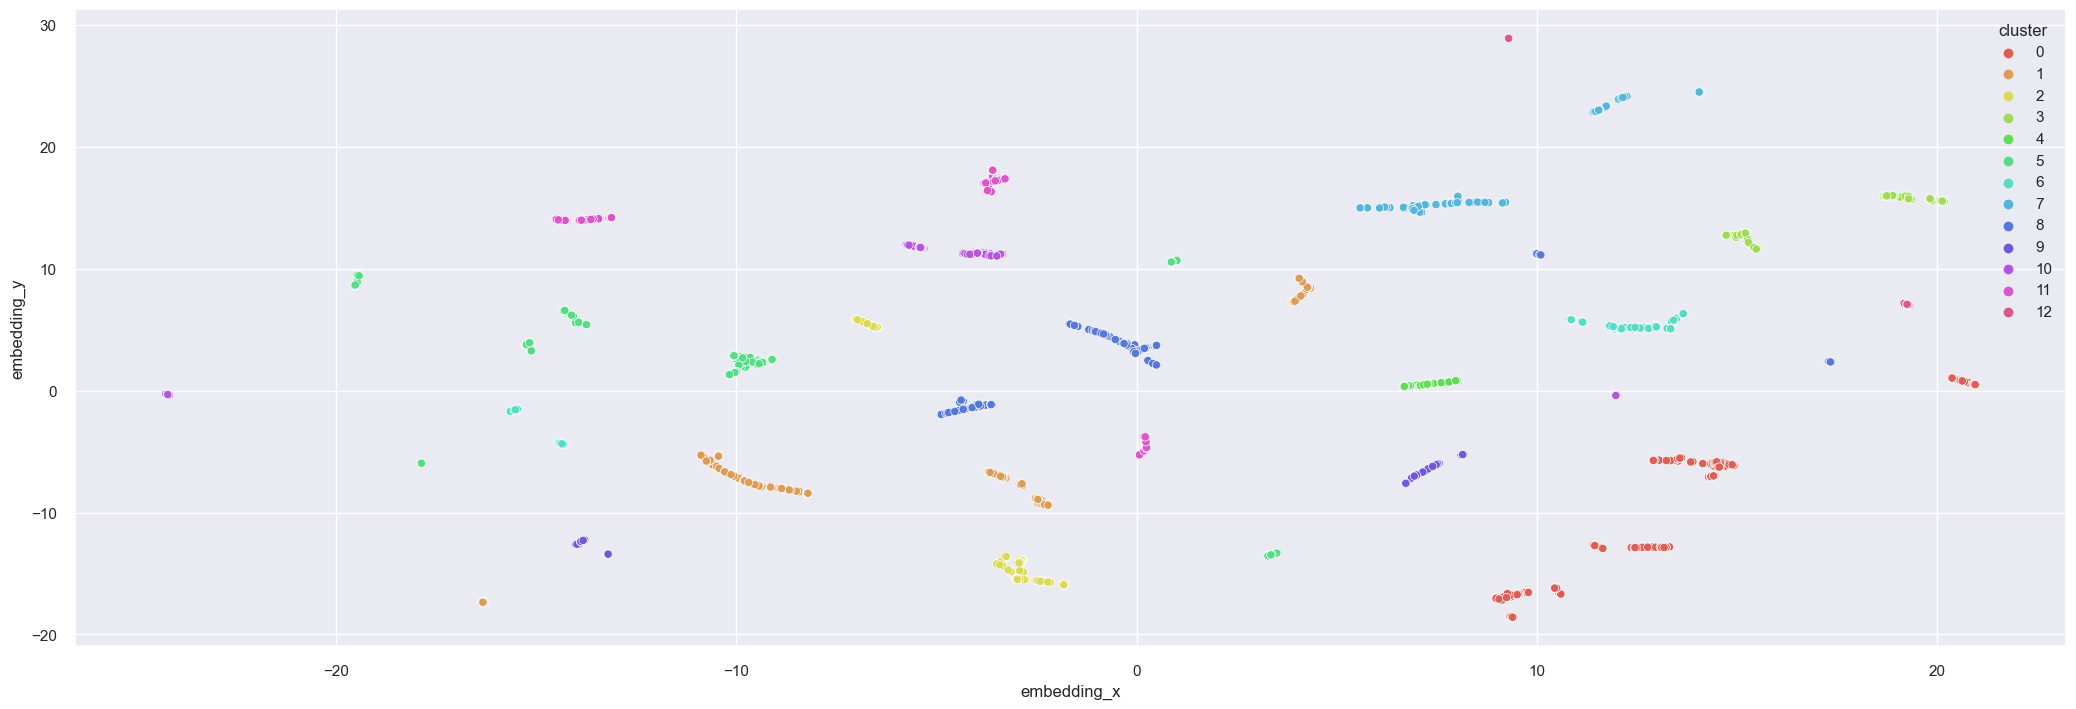

In [98]:
reducer = umap.UMAP( n_neighbors=90, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', 
                hue='cluster', 
                palette=sns.color_palette('hls', n_colors=len( df_viz['cluster'].unique() ) ), 
                data=df_viz ) 

## 9.1. Visualization Inspection

In [99]:
# fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
# fig.show()

## 9.2. Cluster Profile

In [100]:
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_product', 'frequency', 'qtde_returns']
df92 = df4[ cols_selected ].copy()
df92.loc[:, ['cluster'] ] = labels

In [101]:
# Number of customers
df_cluster = df92[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross Revenue 
df_avg_gross_revenue = df92[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster')


# Avg Recency days
df_avg_revency_days = df92[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_revency_days, how='inner', on='cluster')

# Avg invoice no
df_avg_invoice_no = df92[['qtde_product','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Frequency
df_frequency = df92[['frequency','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster')

# Returns
df_returns = df92[['qtde_returns','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_returns, how='inner', on='cluster')

# # Avg ticket
# df_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
# df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster')

df_cluster.sort_values(by='gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_product,frequency,qtde_returns
12,12,37,1.246631,65572.295135,16.108108,1118.513514,0.138570,1221.054054
7,7,255,8.591644,7760.927451,22.698039,336.725490,0.076508,81.882353
3,3,176,5.929919,3900.387727,27.022727,229.409091,0.036884,36.562500
10,10,159,5.357143,2899.615723,37.484277,172.150943,0.144182,28.981132
6,6,205,6.907008,2349.572537,43.068293,153.014634,0.040364,18.117073
2,2,194,6.536388,1901.593711,40.412371,111.716495,0.039108,28.036082
11,11,238,8.018868,1660.996303,32.764706,124.747899,0.031101,17.235294
4,4,68,2.291105,1411.145294,74.132353,91.382353,0.068286,19.220588
0,0,399,13.443396,1066.811328,65.137845,72.776942,0.073493,12.110276
5,5,369,12.432615,799.001978,76.352304,61.718157,0.087674,6.016260


### Cluster 01 (Candidato a Insider) 
    - Número de customers: 6 (0.14% dos customers)
    - Recência média:  7 dias
    - Compras em média: 89 compras 
    - Receita em média: $182.182,00 dólares
    
### Cluster 02
    - Número de customers: 31 (0.70% dos customers)
    - Recência média: 13 dias
    - Compras em média: 53 compras
    - Receita em média: $40.543,00 dólares

### Cluster 03
    - Número de customers: 4335 (99.16% dos customers)
    - Recência média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: $1.372 dólares

# 10.0. Análise Exploratória de Dados

In [102]:
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_product', 'frequency', 'qtde_returns']
df10 = df4[ cols_selected ].copy()
df10.loc[:, ['cluster'] ] = labels
df10.head()

,customer_id,gross_revenue,recency_days,qtde_product,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,10
1,13047,3232.59,56.0,171.0,0.028302,35.0,6
2,12583,6705.38,2.0,232.0,0.040323,50.0,7
3,13748,948.25,95.0,28.0,0.017921,0.0,5
4,15100,876.00,333.0,3.0,0.073171,22.0,9


## 10.1. Mindmap de Hipóteses

1. Fenomeno
2. Entidades ( Customer, Location, Finance, Family )
3. Características da entidade

## 10.1. Hipóteses de Negócio

1. Afirmação
2. Comparação entre variáveis
3. Valor base de comparação

## Hipóteses Compra

1. Os clientes do clusters Insiders usam cartão de crédito em 80% das compras
2. Os clientes do clusters Insiders possuem um ticket médio de 10% acima do cluster 'More Products
3. Os clientes do clusters Insiders possuem um basket size acima de 5 produtos
4. **Os clientes do clusters Insiders possuem um volume (produtos) total de compras acima de 10% de total de compras**
5. **Os clientes do clusters Insiders possuem um volume (faturamento) total de compras acima de 10% de total de compras**
6. **Os clientes do clusters Insiders tem um número de devolução abaixo da média da da base total de clientes.**

### H1: Os clientes do clusters Insiders possuem um volume (produtos) total de compras acima de 10% de total de compras
**Verdadeiro**: O cluster Insiders tem volume (produtos) de 18.76%

In [103]:
insider = 9

# df_sales_insider = 
df_sales_insiders = df10.loc[ df10['cluster']==insider ,['qtde_product']].sum()
df_sales = df10.loc[ : ,['qtde_product']].sum()

df_sales_insiders / df_sales

qtde_product    0.006038
dtype: float64

### H2: Os clientes do clusters Insiders possuem um volume (faturamento) total de compras acima de 10% de total de compras
**Verdadeiro**: O cluster Insiders possui um volume de GMV de 41.2%

In [104]:
insider = 9

# df_sales_insider = 
df_gmv_insiders = df10.loc[ df10['cluster']==insider ,['gross_revenue']].sum()
df_gmv = df10.loc[ : ,['gross_revenue']].sum()

df_gmv_insiders / df_gmv

gross_revenue    0.004378
dtype: float64

### H3: Os clientes do clusters Insiders tem um número de devolução abaixo da média da da base total de clientes

In [105]:
df_return_insiders = df10.loc[ df10['cluster']==insider ,['qtde_returns']].mean()
df_return = df10.loc[ : ,['qtde_returns']].mean()

df_return_insiders / df_return

qtde_returns    0.207621
dtype: float64

In [106]:
df_return_insiders

qtde_returns    7.24359
dtype: float64

In [107]:
df_return

qtde_returns    34.888477
dtype: float64

## Hipóteses Cliente

1. 60% do cluster Insiders possuem estado civil de solteiro
2. 10% dos clientes do cluster Insiders estão na faixa de 24-35 anos
3. 40% das localidades de entrega do cluster Insiders estão dentro de um raio de 50km
4. 05% dos clientes do cluster Insiders recebem mais de 100 mil dólares anualmente.
5. 90% dos clientes do cluster Insiders tem ensino superior completo

## Hipóteses Produto

1. 30% de todos os produtos em pacotes grandes são comprados pelos clientes do cluster Insiders
2. A mediana dos preços dos produtos comprados pelos clientes do cluster Insider é 10% maior do que a mediana de todos os preços dos produtos
3. O percentil do preço dos produtos comprados pelos clientes Insiders
4. O peso médio dos produtos comprados pelos clientes do cluster Insiders é maior do que o peso médio dos outros clusters.
5. A idade média dos produtos comprados pelos clientes do cluster Insiders é menor do que 15 dias.

# 10.0. Deploy to Production

In [108]:
df9.head()

,embedding_x,embedding_y,cluster
0,17.372608,-3.964289,10
1,12.557136,-6.194443,6
2,13.639613,13.760060,7
3,-7.713752,0.881671,5
4,-0.932450,19.811493,9


# Insert into SQLite

In [122]:
import sqlite3
from sqlalchemy import create_engine

In [123]:
df93 = df92.copy()

In [124]:
df93['customer_id']   = df93['customer_id'].astype('int64')
df93['recency_days']  = df93['recency_days'].astype('int64')
df93['qtde_product'] = df93['qtde_product'].astype('int64')
df93['qtde_returns']  = df93['qtde_returns'].astype('int64')

In [128]:
query_create_table_insiders = """
    CREATE TABLE insiders (
            customer_id       INTEGER,
            gross_revenue     REAL,
            recency_days      INTEGER,
            qtde_product     INTEGER,
            frequency         REAL,
            qtde_returns      INTEGER,
            cluster           INTEGER    
    )
"""

conn = sqlite3.connect('insiders_db.sqlite')
conn.execute( query_create_table_insiders )
conn.commit()
conn.close()

In [127]:
conn = sqlite3.connect('insiders_db.sqlite')
conn.execute( 'DROP TABLE IF EXISTS insiders' )
conn.commit()
conn.close()

In [129]:
# create_engine( 'sqlite:///Users/leonardo.ribeiro/repos/pa005/pa005_insiders_clustering/notebooks/insiders_db.sqlite')
conn = create_engine( 'sqlite:///insiders_db.sqlite')
df93.to_sql('insiders', con=conn, if_exists='append', index=False)

In [130]:
### consulting database
query = " select * from insiders"

In [131]:
df_testeeee = pd.read_sql_query( query, conn )
df_testeeee.head()

,customer_id,gross_revenue,recency_days,qtde_product,frequency,qtde_returns,cluster
0,17850,5391.21,372,297,17.000000,40,10
1,13047,3232.59,56,171,0.028302,35,6
2,12583,6705.38,2,232,0.040323,50,7
3,13748,948.25,95,28,0.017921,0,5
4,15100,876.00,333,3,0.073171,22,9
